In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from dotenv import load_dotenv
from sklearn.cluster import KMeans
import os

In [29]:
load_dotenv('../.venv/.env')

True

In [30]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
table_name = 'xdr_data'

In [31]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)

In [32]:
query = 'SELECT * FROM xdr_data'
data = pd.read_sql(query, engine)

In [33]:
print(data.head)

<bound method NDFrame.head of            Bearer Id            Start  Start ms              End     End ms  \
0       1.311448e+19   4/4/2019 12:01  770.0000  4/25/2019 14:35  662.00000   
1       1.311448e+19   4/9/2019 13:04  235.0000   4/25/2019 8:15  606.00000   
2       1.311448e+19   4/9/2019 17:42    1.0000  4/25/2019 11:58  652.00000   
3       1.311448e+19   4/10/2019 0:31  486.0000   4/25/2019 7:36  171.00000   
4       1.311448e+19  4/12/2019 20:10  565.0000  4/25/2019 10:40  954.00000   
...              ...              ...       ...              ...        ...   
149996  7.277826e+18   4/29/2019 7:28  451.0000   4/30/2019 6:02  214.00000   
149997  7.349883e+18   4/29/2019 7:28  483.0000  4/30/2019 10:41  187.00000   
149998  1.311448e+19   4/29/2019 7:28  283.0000  4/30/2019 10:46  810.00000   
149999  1.311448e+19   4/29/2019 7:28  696.0000  4/30/2019 10:40  327.00000   
150000  1.013887e+19              N/A  499.1882              N/A  498.80088   

           Dur. (ms) 

In [34]:
# Handle outliers
for col in ['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, data[col].mean(), data[col])
    data[col] = np.where(data[col] > upper_bound, data[col].mean(), data[col])

# Aggregate per customer
agg_df = data.groupby('IMSI').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean',
    'Handset Type': lambda x: x.mode()[0]
}).reset_index()

# Calculate total TCP retransmission, RTT, and throughput
agg_df['total_tcp'] = (agg_df['TCP DL Retrans. Vol (Bytes)'] + agg_df['TCP UL Retrans. Vol (Bytes)'])
agg_df['total_rtt'] = (agg_df['Avg RTT DL (ms)'] + agg_df['Avg RTT UL (ms)'])
agg_df['total_throughput'] = (agg_df['Avg Bearer TP DL (kbps)'] + agg_df['Avg Bearer TP UL (kbps)'])

# Drop the intermediary columns
agg_df = agg_df.drop(columns=[
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)'
])

**Cluster**

In [35]:
from sklearn.cluster import KMeans
import pandas as pd

X = agg_df[['total_tcp', 'total_rtt', 'total_throughput']]

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Create a DataFrame for the cluster centers
cluster_description = pd.DataFrame(cluster_centers, columns=['total_tcp', 'total_rtt', 'total_throughput'])

# View the cluster centers to identify "less engaged" and "worst experience" clusters
print(cluster_description)


      total_tcp  total_rtt  total_throughput
0  2.169953e+07  74.705766       1861.692290
1  1.205007e+06  85.364916      17428.910921
2  1.144526e+07  76.380355      12764.432642


**Engagement and Experience Scores (Euclidean Distance)**

In [36]:
from scipy.spatial.distance import euclidean

# Assign engagement and experience cluster centroids
engagement_centroid = cluster_description.loc[0, ['total_tcp', 'total_rtt', 'total_throughput']]
experience_centroid = cluster_description.loc[2, ['total_tcp', 'total_rtt', 'total_throughput']]

# Function to calculate Euclidean distance
def calculate_scores(row, centroid):
    return euclidean(row[['total_tcp', 'total_rtt', 'total_throughput']], centroid)

# Calculate engagement and experience scores
agg_df['engagement_score'] = agg_df.apply(lambda row: calculate_scores(row, engagement_centroid), axis=1)
agg_df['experience_score'] = agg_df.apply(lambda row: calculate_scores(row, experience_centroid), axis=1)

# Display engagement and experience scores
print(agg_df[['IMSI', 'engagement_score', 'experience_score']].head())


           IMSI  engagement_score  experience_score
0  2.040471e+14      1.299680e+05      1.012432e+07
1  2.040808e+14      1.299681e+05      1.012432e+07
2  2.082001e+14      2.093717e+07      1.068291e+07
3  2.082001e+14      2.167155e+07      1.141729e+07
4  2.082001e+14      1.299669e+05      1.012432e+07


**Satisfaction Score andTop 10 Satisfied Customers**

In [37]:
# Calculate satisfaction score as the average of engagement and experience scores
agg_df['satisfaction_score'] = (agg_df['engagement_score'] + agg_df['experience_score']) / 2

# Display satisfaction scores
print(agg_df[['IMSI', 'satisfaction_score']].head())

# Sort users by satisfaction score in descending order and get the top 10
top_10_satisfied_customers = agg_df[['IMSI', 'satisfaction_score']].sort_values(by='satisfaction_score', ascending=False).head(10)

           IMSI  satisfaction_score
0  2.040471e+14        5.127144e+06
1  2.040808e+14        5.127144e+06
2  2.082001e+14        1.581004e+07
3  2.082001e+14        1.654442e+07
4  2.082001e+14        5.127143e+06


In [38]:
# Display the top 10 satisfied customers
print(top_10_satisfied_customers)

                IMSI  satisfaction_score
58929   2.082017e+14        3.403246e+07
7080    2.082003e+14        3.374560e+07
81736   2.082018e+14        3.368701e+07
81285   2.082018e+14        3.359533e+07
100291  2.082021e+14        3.356362e+07
81247   2.082018e+14        3.356104e+07
59500   2.082017e+14        3.351541e+07
46558   2.082015e+14        3.346670e+07
30893   2.082014e+14        3.343167e+07
640     2.082003e+14        3.327047e+07


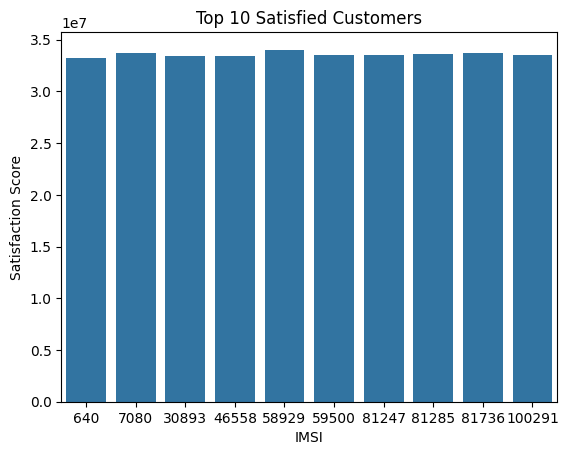

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the IMSI and satisfaction scores
imsi = [58929, 7080, 81736, 81285, 100291, 81247, 59500, 46558, 30893, 640]
satisfaction_scores = [3.403246e+07, 3.374560e+07, 3.368701e+07, 3.359533e+07, 3.356362e+07, 3.356104e+07, 3.351541e+07, 3.346670e+07, 3.343167e+07, 3.327047e+07]

# Create a seaborn barplot
sns.barplot(x=imsi, y=satisfaction_scores)
plt.xlabel('IMSI')
plt.ylabel('Satisfaction Score')
plt.title('Top 10 Satisfied Customers')
plt.show()



**Build a Regression Model to Predict Satisfaction Score**

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data
X = agg_df[['engagement_score', 'experience_score']]
y = agg_df['satisfaction_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Save model
import joblib
joblib.dump(model, 'satisfaction_model.pkl')

Mean Squared Error: 2.4262711028758966e-15


['satisfaction_model.pkl']

**K-Means Clustering on Engagement and Experience Scores**

In [40]:
X_kmeans = agg_df[['engagement_score', 'experience_score']]

# Run KMeans clustering with k=2
kmeans_2 = KMeans(n_clusters=2, random_state=42)
agg_df['kmeans_cluster'] = kmeans_2.fit_predict(X_kmeans)

print(agg_df[['IMSI', 'kmeans_cluster']].head())


           IMSI  kmeans_cluster
0  2.040471e+14               0
1  2.040808e+14               0
2  2.082001e+14               1
3  2.082001e+14               1
4  2.082001e+14               0


In [57]:
# calculate cluster statistics
import pandas as pd
cluster_stats = agg_df.groupby('kmeans_cluster')[['engagement_score', 'experience_score']].mean()
print(cluster_stats)

                engagement_score  experience_score
kmeans_cluster                                    
0                   6.123611e+05      9.796971e+06
1                   1.742301e+07      7.515615e+06


**Aggregate Average Satisfaction and Experience Scores per Cluster**

In [42]:
cluster_agg = agg_df.groupby('kmeans_cluster')[['satisfaction_score', 'experience_score']].mean()

print(cluster_agg)


                satisfaction_score  experience_score
kmeans_cluster                                      
0                     5.204666e+06      9.796971e+06
1                     1.246931e+07      7.515615e+06


**Export to Postgres DB**

In [63]:
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.types import BigInteger, Float
import os

db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)


agg_df = pd.DataFrame({
    'IMSI': [204047108489451, 204080810288647, 208200101016140, 208200101127285, 208200101148045, 208200101148074, 208200101148075, 208200101148136, 208200101148139, 208200101148152],
    'engagement_score': [129968.04258323665, 129968.05689592577, 20937172.06993773, 21671548.689636376, 129966.93348582451, 129967.61677964486, 129966.90651131945, 10331094.362011045, 21008299.326391716, 129966.73500976048],
    'experience_score': [10124319.290019833, 10124319.291280454, 10682913.520634435, 11417289.006447075, 10124319.191252466, 10124319.252247123, 10124319.188758623, 77614.19941899911, 10754029.135384595, 10124319.172025776],
    'satisfaction_score': [5127143.6663015345, 5127143.67408819, 15810042.795286082, 16544418.848041724, 5127143.062369145, 5127143.434513384, 5127143.047634971, 5204354.280715022, 15881164.230888154, 5127142.953517768]
})

# Insert the DataFrame into the PostgreSQL table
agg_df[['IMSI', 'engagement_score', 'experience_score', 'satisfaction_score']].to_sql(
    'customer_scores', 
    engine, 
    if_exists='replace',  
    index=False,  
    dtype={
        'IMSI': BigInteger(), 
        'engagement_score': Float(), 
        'experience_score': Float(),
        'satisfaction_score': Float()
    }
)

# Verify the inserted data
with engine.connect() as connection:
    result = connection.execute(text("SELECT * FROM customer_scores LIMIT 10")).fetchall()
    for row in result:
        print(row)

(204047108489451, 129968.04258323665, 10124319.290019833, 5127143.6663015345)
(204080810288647, 129968.05689592577, 10124319.291280454, 5127143.67408819)
(208200101016140, 20937172.06993773, 10682913.520634435, 15810042.795286082)
(208200101127285, 21671548.689636376, 11417289.006447075, 16544418.848041724)
(208200101148045, 129966.93348582451, 10124319.191252466, 5127143.062369145)
(208200101148074, 129967.61677964486, 10124319.252247123, 5127143.434513384)
(208200101148075, 129966.90651131945, 10124319.188758623, 5127143.047634971)
(208200101148136, 10331094.362011045, 77614.19941899911, 5204354.280715022)
(208200101148139, 21008299.326391716, 10754029.135384595, 15881164.230888154)
(208200101148152, 129966.73500976048, 10124319.172025776, 5127142.953517768)


In [25]:
# Query for data and create a DataFrame for visualization
with engine.connect() as connection:
    query = text("SELECT * FROM customer_scores")
    df = pd.read_sql(query, connection)

**Model Deployment**

In [52]:
import mlflow

import mlflow
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def train_and_log_model(engagement, experience, satisfaction):
    """Trains a linear regression model and logs metrics and artifacts to MLflow."""

    with mlflow.start_run():

        mlflow.log_param("model_type", "linear_regression")
        mlflow.log_param("test_size", 0.2)

        X = agg_df[['engagement_score', 'experience_score']]

        X_train, X_test, y_train, y_test = train_test_split(
            X, satisfaction, test_size=0.2, random_state=0
        )

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        mlflow.log_metric("mse", mse)

        mlflow.sklearn.log_model(model, "linear_regression_model")

train_and_log_model(agg_df[['engagement_score']], agg_df[['experience_score']], agg_df['satisfaction_score'])

2024/09/11 10:45:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
